In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager

In [2]:
#缓存（cache）装饰器
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

In [3]:
#下载函数
@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

In [4]:
help(cache_data)

Help on function cache_data in module __main__:

cache_data(src: pathlib.Path, dst: pathlib.Path) -> str
    Downloads a remote file.

    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.

    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.

    Returns
    -------
    str
        A string representing the local location of the file.



In [5]:
#下载/读取地理数据
ddir  = Path('data/geo')
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir.resolve()) )

print('Done.')

+ /home/jovyan/work/The-Universe-s-Premier-F/data/geo/Boroughs.gpkg not found, downloading!
 + Done downloading...
Done.


In [6]:
# Input: date + city
ymd  = '20250615'
city = 'London'
host = "https://raw.githubusercontent.com"
repo = "yjzhou217/The-Universe-s-Premier-F/main"

url  = f"{host}/{repo}/{ymd}-{city}-listings.csv.gz"
print(url)

# 创建 data/raw 文件夹
Path("data/raw").mkdir(parents=True, exist_ok=True)

# load csv
file_path = cache_data(url, Path("data/raw").resolve())

df = pd.read_csv(file_path, compression="gzip", low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")


https://raw.githubusercontent.com/yjzhou217/The-Universe-s-Premier-F/main/20250615-London-listings.csv.gz
+ /home/jovyan/work/The-Universe-s-Premier-F/data/raw/20250615-London-listings.csv.gz not found, downloading!
 + Done downloading...
Data frame is 96,651 x 79


In [7]:
#clean csv data
#testing mode
TESTING = False

if TESTING:
    N = 10_000
else:
    N = None  # None = read all

df = pd.read_csv(
    file_path,
    nrows=N,
    low_memory=False
)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [8]:
#随机抽样
df.sample(3, random_state=42)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
55322,940318502107598761,https://www.airbnb.com/rooms/940318502107598761,20250610032232,2025-06-12,city scrape,Lovely flat in West London,Calm and tranquil flat just off Portobello Roa...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,12260283,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
82794,1316092340060307099,https://www.airbnb.com/rooms/1316092340060307099,20250610032232,2025-06-14,previous scrape,Short walk from local amenities,Keep it simple at this peaceful and centrally-...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,667965836,...,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
21163,25321683,https://www.airbnb.com/rooms/25321683,20250610032232,2025-06-13,previous scrape,"Bright, modern flat near Finsbury Park","Light, modern 1-bedroom flat situated next to ...",NaN,https://a0.muscache.com/pictures/ff89be9e-bced...,5768769,...,5.0,5.0,5.0,NaN,t,1,1,0,0,0.01


In [9]:
#clean data
#删除id缺失的行
missing_id_rows = df[df['id'].isna()][['id', "latitude", "longitude", 'room_type']]
print(f"{missing_id_rows.shape[0]:,}")
if missing_id_rows.shape[0] > 0:
    print(missing_id_rows.head())

df.drop(df[df['id'].isna()].index, axis=0, inplace=True)
print(f"{df.shape[0]:,} x {df.shape[1]}")

0
96,651 x 79


In [10]:
#寻找垃圾列
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]

license                         96651
calendar_updated                96651
neighbourhood_group_cleansed    96651
neighborhood_overview           54668
neighbourhood                   54667
host_neighbourhood              50360
host_about                      47337
beds                            33975
price                           33967
estimated_revenue_l365d         33967
bathrooms                       33921
host_response_rate              33024
dtype: int64

In [11]:
#删除全是nan的列
df.drop(columns=['license','calendar_updated','neighbourhood_group_cleansed'], inplace=True)

In [12]:
#寻找垃圾行
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

6122     33
5155     33
4622     33
3646     32
30641    31
5535     31
58822    28
86012    27
87970    27
34580    27
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

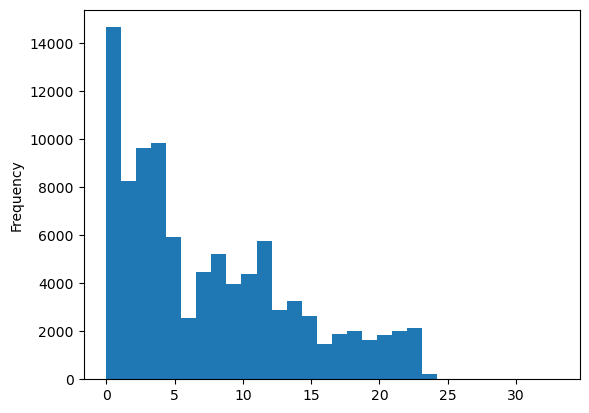

In [13]:
#绘制 histogram
probs = df.isnull().sum(axis=1)
print(type(probs))
probs.plot.hist(bins=30)

In [14]:
#考虑删除缺失超过25个值的行
print(f"df contains {df.shape[0]:,} rows.")
cutoff = 25
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows.")

df contains 96,651 rows.
df contains 96,639 rows.


In [15]:
#Fixing Data Types
#把分类变量变成category，包括source、property_type、room_type、neighbourhood、neighbourhood_cleansed、host_response_time
cols_to_category = [
    'source', 'property_type', 'room_type',
    'neighbourhood', 'neighbourhood_cleansed',
    'host_response_time'
]

for col in cols_to_category:
    df[col] = df[col].astype('category')

#字符串布尔变成Boolean
bool_cols = [
    'host_has_profile_pic',
    'host_identity_verified',
    'host_is_superhost',
    'has_availability',
    'instant_bookable'
]

for col in bool_cols:
    df[col] = df[col].replace({'t': True, 'f': False}).astype(bool)

#转换日期格式
date_cols = [
    'host_since',
    'last_scraped',
    'calendar_last_scraped',
    'first_review',
    'last_review'          
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

#Dealing with Strings（price）
money = ['price']
for m in money:
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

#Dealing with Integers（处理整数列）
int_cols = [
    'id', 'host_id', 'host_listings_count', 'host_total_listings_count',
    'accommodates', 'beds', 'bedrooms', 'minimum_nights', 'maximum_nights',
    'availability_30','availability_60','availability_90','availability_365',
    'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','number_of_reviews_ly'
]

for col in int_cols:
    print(f"Converting {col}")
    try:
        df[col] = df[col].astype('float').astype('int')
    except ValueError as e:
        print(f"  - Warning: {col} has missing or non-integer values, converting to nullable UInt16")
        df[col] = df[col].astype('float').astype(pd.UInt16Dtype())

/tmp/ipykernel_160030/1744722621.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'t': True, 'f': False}).astype(bool)


Converting id
Converting host_id
Converting host_listings_count
  - Warning: host_listings_count has missing or non-integer values, converting to nullable UInt16
Converting host_total_listings_count
  - Warning: host_total_listings_count has missing or non-integer values, converting to nullable UInt16
Converting accommodates
Converting beds
  - Warning: beds has missing or non-integer values, converting to nullable UInt16
Converting bedrooms
  - Warning: bedrooms has missing or non-integer values, converting to nullable UInt16
Converting minimum_nights
Converting maximum_nights
Converting availability_30
Converting availability_60
Converting availability_90
Converting availability_365
Converting number_of_reviews
Converting number_of_reviews_ltm
Converting number_of_reviews_l30d
Converting number_of_reviews_ly


In [16]:
#Validation
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96639 entries, 0 to 96650
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            96639 non-null  int64         
 1   listing_url                                   96639 non-null  object        
 2   scrape_id                                     96639 non-null  int64         
 3   last_scraped                                  96639 non-null  datetime64[ns]
 4   source                                        96639 non-null  category      
 5   name                                          96639 non-null  object        
 6   description                                   93794 non-null  object        
 7   neighborhood_overview                         41982 non-null  object        
 8   picture_url                                   96630 non-null  object   

In [17]:
#Saving
from pathlib import Path

# 输出文件路径
csv_out = Path(f"data/clean/{file_path.name}") 
pq_out  = Path(f"data/clean/{file_path.name.replace('.csv.gz','.parquet')}")

# 创建文件夹（如果不存在）
if not csv_out.parent.exists():
    print(f"Creating folder {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)

# 保存 CSV 和 Parquet
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)

print(f"Saved {df.shape[0]:,} rows of {df.shape[1]} columns to {csv_out.resolve()}")
print("Done.")

Creating folder data/clean
Saved 96,639 rows of 76 columns to /home/jovyan/work/The-Universe-s-Premier-F/data/clean/20250615-London-listings.csv.gz
Done.


In [18]:
#导入clean完的Parquet
parquet_path = Path("data/clean") / file_path.name.replace(".csv.gz", ".parquet")
df = pd.read_parquet(parquet_path)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,639 x 76


In [19]:
#从 DataFrame 创建 GeoDataFrame（把 lon/lat 转为 geometry）
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [20]:
#保存 geo parquet
gdf.to_parquet(Path(f'data/geo/{ymd}-{city}-listings.geoparquet').resolve())
print(type(gdf))
print(type(gdf.geometry))
gdf.geometry.iloc[1:5]

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry

In [21]:
#检查crs
for g in [boros, gdf]:
    print(g.crs)

EPSG:27700
epsg:4326


In [22]:
#重投影
gdf = gdf.to_crs('epsg:27700') 
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[504186.07291139 156900.42075072 558044.54194941 200027.74372136]


In [23]:
#1.1airbnb在空间上的分布，集中在哪个区域
fontname = "Roboto Slab"

matplotlib.font_manager.FontManager().findfont(fontname, fontext='ttf', rebuild_if_missing=True)

import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

tgdf = gdf[
    (~gdf.price.isna()) &
    (gdf.price > 0) ].copy()

print(f"Loaded: {gdf.shape[0]} rows.")
print(f"Selected: {tgdf.shape[0]} rows.")

/opt/conda/lib/python3.12/site-packages/pysal/lib/io/fileio.py:43: SyntaxWarning: invalid escape sequence '\*'
  FileIO.open(\*args) == FileIO(\*args)
/opt/conda/lib/python3.12/site-packages/pysal/lib/weights/weights.py:405: SyntaxWarning: invalid escape sequence '\s'
  s0=\sum_i \sum_j w_{i,j}
/opt/conda/lib/python3.12/site-packages/pysal/lib/weights/weights.py:419: SyntaxWarning: invalid escape sequence '\s'
  s1=1/2 \sum_i \sum_j (w_{i,j} + w_{j,i})^2
/opt/conda/lib/python3.12/site-packages/pysal/lib/weights/weights.py:451: SyntaxWarning: invalid escape sequence '\s'
  s2=\sum_j (\sum_i w_{i,j} + \sum_i w_{j,i})^2
/opt/conda/lib/python3.12/site-packages/pysal/lib/weights/weights.py:1027: SyntaxWarning: invalid escape sequence '\i'
  symmetry is defined as :math:`i \in N_j \ AND \ j \in N_i` where
/opt/conda/lib/python3.12/site-packages/pysal/lib/weights/weights.py:1357: SyntaxWarning: invalid escape sequence '\s'
  s0=\sum_i \sum_j w_{i,j}
/opt/conda/lib/python3.12/site-packages/pys

Loaded: 96639 rows.
Selected: 62678 rows.


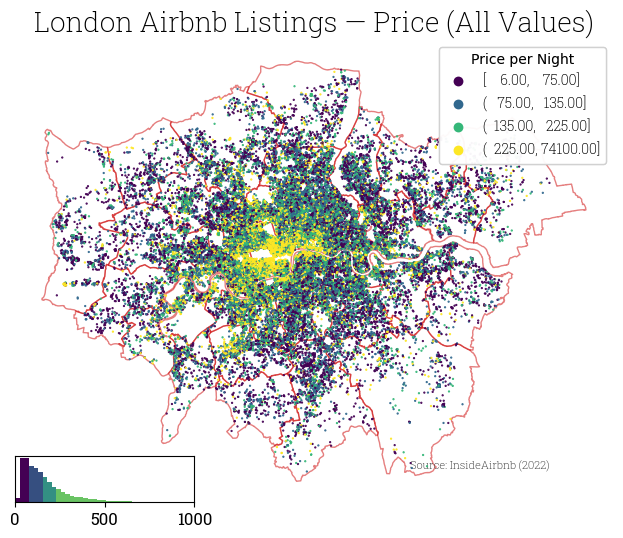

In [24]:
q = mc.Quantiles(tgdf.price.values, k=4)

tgdf['bins'] = q.yb

f,ax = plt.subplots(figsize=(8,6))
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=1, zorder=1, ax=ax)

ax.axis('off') 

tgdf.plot(column='bins', categorical=True,
         cmap='viridis', legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

ax.set_title('London Airbnb Listings — Price (All Values)',
             fontdict={'fontsize':'20', 'fontweight':'3', 'family':fontname}) 

for c in ax.collections:
    if c.get_zorder()==4:
        handles, _ = c.legend_elements(prop="colors")
        legend1 = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'),
                            loc="upper right", title="Price per Night",
                            prop={'size':'10', 'weight':'1', 'family':fontname})
        ax.add_artist(legend1)

a = ax.text(tgdf.geometry.x.max(), tgdf.geometry.y.min(), 'Source: InsideAirbnb (2022)',
             horizontalalignment='right', verticalalignment='bottom',
             fontsize=8, fontweight=2, color='#333333', family=fontname)

ax2 = legendgram(f, ax,
           tgdf.price, q.bins, bins=round(gdf.price.max()/25),
           pal=palmpl.Viridis_4,
           legend_size=(0.3, 0.1),
           loc='lower left',
           clip=(0,1000),
           frameon=True
    )

for tk in ax2.get_xticklabels():
    tk.set_fontname(fontname)

In [25]:
#

gdf has 96,639 rows.
The range of ln(price) is 1.9459 to 11.2132


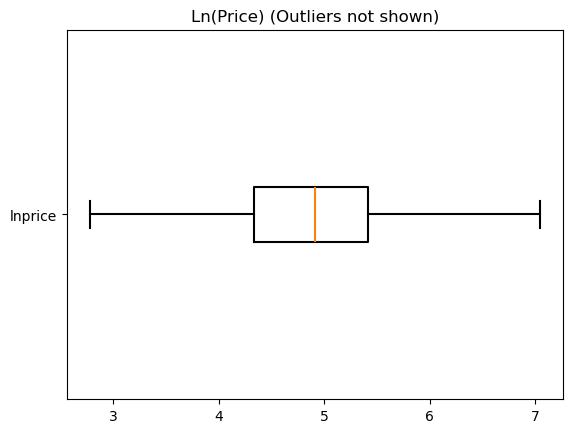

In [26]:
print(f"gdf has {gdf.shape[0]:,.0f} rows.")

gdf['lnprice'] = np.log(gdf.price + 1)

print(f"The range of ln(price) is {gdf.lnprice.min():,.4f} to {gdf.lnprice.max():,.4f}")

gdf.lnprice.plot(kind='box', vert=False,
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Ln(Price) (Outliers not shown)")
plt.show()

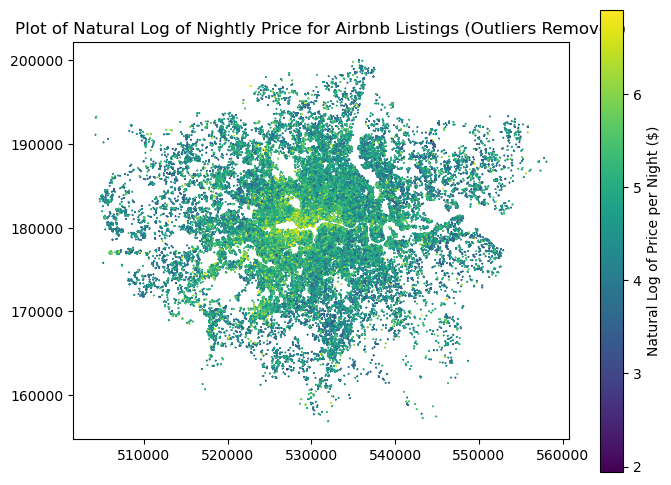

In [27]:
ax = gdf[(gdf.lnprice > 0) & (gdf.lnprice < np.log(1000))].plot(figsize=(8,6), marker='*', markersize=0.25, column='lnprice', cmap='viridis', legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)");

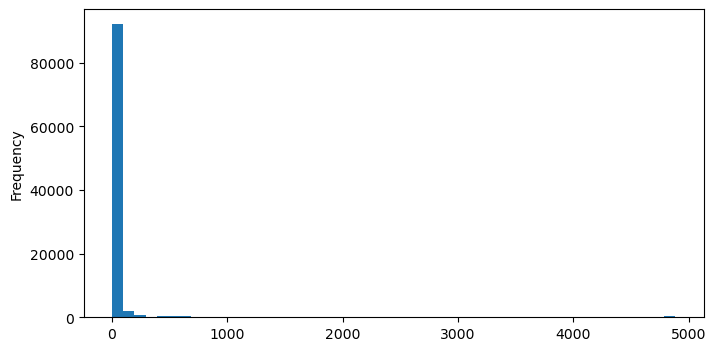

In [53]:
df.host_listings_count.plot.hist(bins=50, figsize=(8,4));


In [32]:
#找出所有房东数量
total_hosts = gdf['host_id'].nunique()
print("总房东数量：", total_hosts)

总房东数量： 55794


In [33]:
#筛选专业房东的方式
filtered = gdf[
    (gdf['room_type'] == 'Entire home/apt') &
    (gdf['host_listings_count'] >= 2)
]

In [34]:
len(filtered) / len(gdf)
print(f"counting for：{len(filtered)/len(gdf):.2%}")

counting for：38.08%


In [35]:
#找出这些专业房东（host_id）是谁
target_hosts = gdf[
    (gdf['room_type'] == 'Entire home/apt') &
    (gdf['host_listings_count'] >= 2)
]['host_id'].unique()

In [44]:
#计算专业房东占比
ratio = len(target_hosts) / total_hosts
print(f"比例：{ratio:.2%}")

比例：20.03%


In [36]:
#受影响的房源数量
pro_host_all_listings = gdf[gdf['host_id'].isin(target_hosts)]

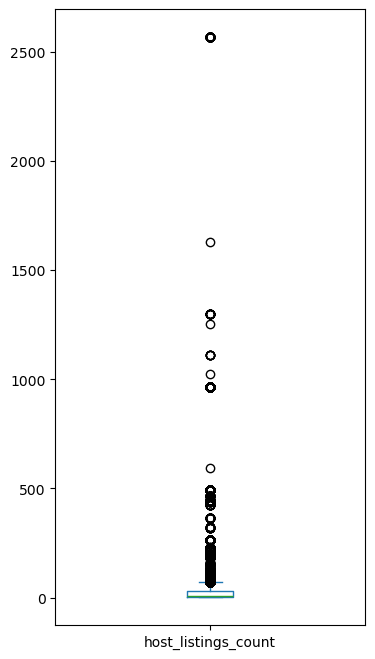

In [82]:
#不同房东箱线图
pro_host_all_listings.host_listings_count.plot.box(figsize=(4, 8));

In [42]:
affected = len(pro_host_all_listings)
unaffected = len(df) - affected

In [44]:
import pandas as pd

compare = pd.Series({
    'affected': affected,
    'unaffected': unaffected
})

print(compare)

affected      44231
unaffected    52408
dtype: int64


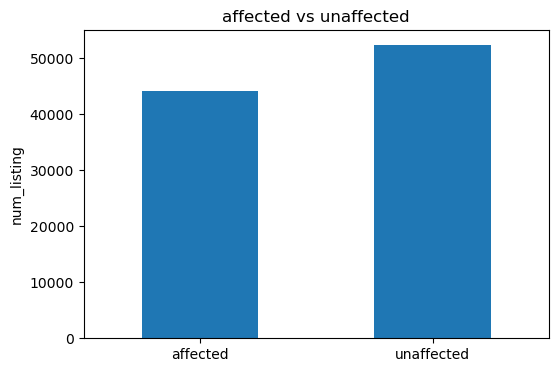

In [45]:
compare.plot(kind='bar', figsize=(6,4))
plt.title("affected vs unaffected")
plt.ylabel("num_listing")
plt.xticks(rotation=0)
plt.show()

In [46]:
#这些房东持有多少套房
pro_host_all_listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,lnprice
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.62,4.72,True,11,11,0,0,0.51,POINT (537737.328 173423.242),5.697093
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,None,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.54,4.42,True,11,11,0,0,0.22,POINT (537703.938 173397.858),4.595120
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.36,4.38,True,11,11,0,0,0.43,POINT (537508.499 173476.041),5.003946
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.50,4.47,True,11,11,0,0,0.30,POINT (537484.993 173470.956),4.976734
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,None,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.37,4.59,True,11,11,0,0,0.35,POINT (537487.042 173446.529),5.062595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96634,1439537980917449216,https://www.airbnb.com/rooms/1439537980917449228,20250610032232,2025-06-13,city scrape,flat in shoreditch,Your family will be close to everything when y...,None,https://a0.muscache.com/pictures/hosting/Hosti...,698200683,...,NaN,NaN,True,3,1,2,0,NaN,POINT (533808.385 182476.606),7.241366
96635,1439588527887649792,https://www.airbnb.com/rooms/1439588527887649898,20250610032232,2025-06-12,city scrape,Bright & Modern Studio in Dalston with a Patio E8,A perfectly located bright and contemporary st...,None,https://a0.muscache.com/pictures/miso/Hosting-...,1190865,...,NaN,NaN,True,4,4,0,0,NaN,POINT (533504.175 184436.027),4.564348
96636,1439655439747195648,https://www.airbnb.com/rooms/1439655439747195716,20250610032232,2025-06-13,city scrape,Modern 2 Bed 2bth in central Heart of London,"Modern 2-bed, 2-bath apartment in the heart of...",None,https://a0.muscache.com/pictures/hosting/Hosti...,501629235,...,NaN,NaN,True,3,3,0,0,NaN,POINT (527205.903 181498.693),5.703782
96637,1439664697712208640,https://www.airbnb.com/rooms/1439664697712208758,20250610032232,2025-06-12,city scrape,Chic apt close to Westminster,Surround yourself with style in this standout ...,None,https://a0.muscache.com/pictures/miso/Hosting-...,2125620,...,NaN,NaN,True,49,49,0,0,NaN,POINT (529693.69 179128.455),8.006701


In [47]:
#分房型看看这些房东出租什么类型的房子
pro_host_all_listings['room_type'].value_counts(normalize=True)

room_type
Entire home/apt    0.831973
Private room       0.166535
Hotel room         0.000882
Shared room        0.000610
Name: proportion, dtype: float64

<Axes: xlabel='longitude', ylabel='latitude'>

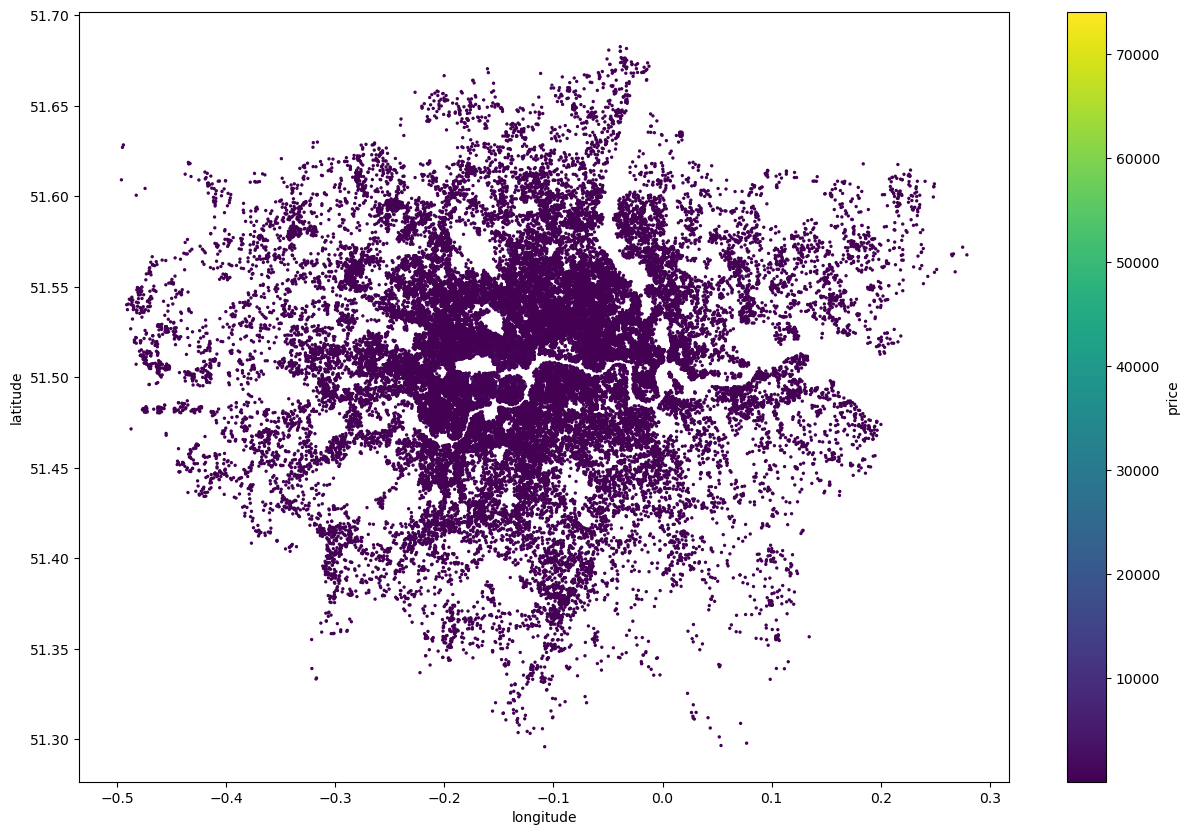

In [48]:
#Scatterplots
df.plot.scatter(x='longitude', y='latitude', c='price', s=2, cmap='viridis', figsize=(15,10))

<Axes: xlabel='longitude', ylabel='latitude'>

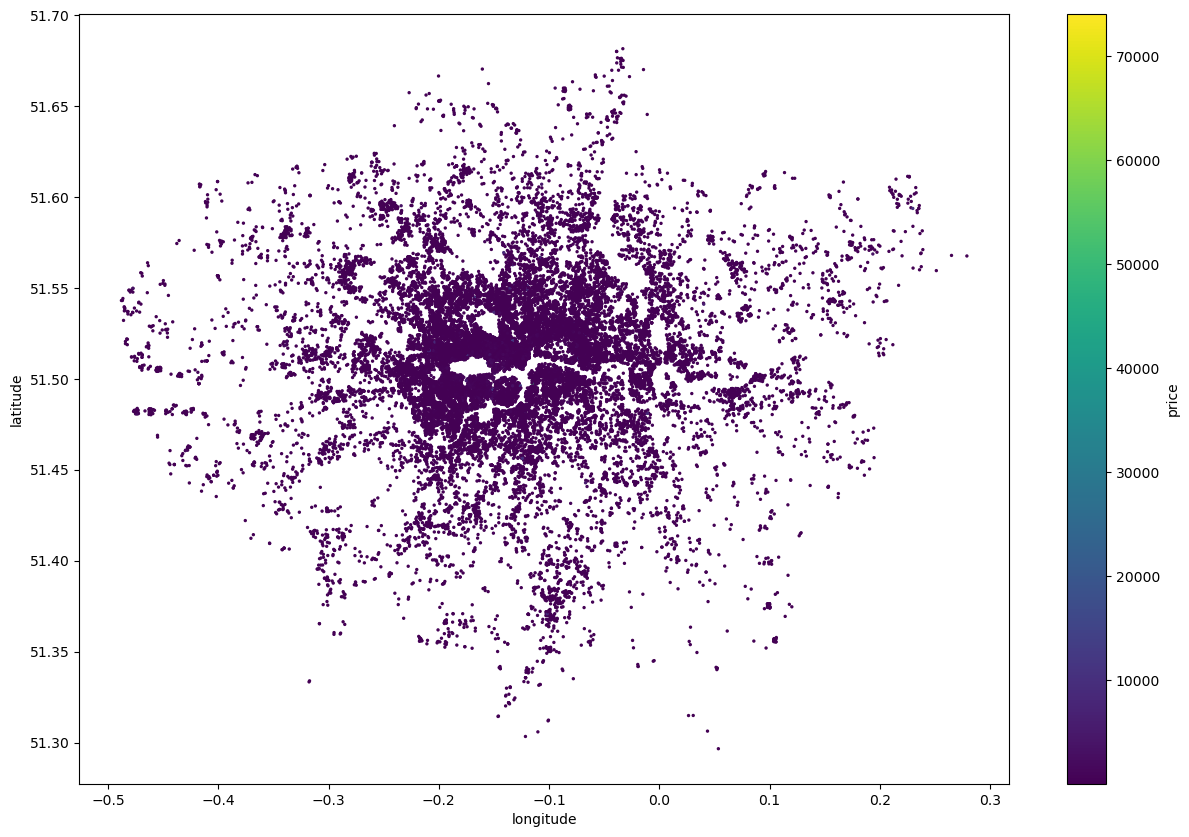

In [49]:
#房源空间分布（scatter 图）
pro_host_all_listings.plot.scatter(
    x='longitude',
    y='latitude',
    s=2,
    c='price',
    cmap='viridis',
    figsize=(15,10)
)

In [50]:
#收入总潜力
pro_host_all_listings = df[df['host_id'].isin(target_hosts)].copy()

pro_host_all_listings['potential_revenue'] = (
    pro_host_all_listings['price'] * pro_host_all_listings['availability_365']
)

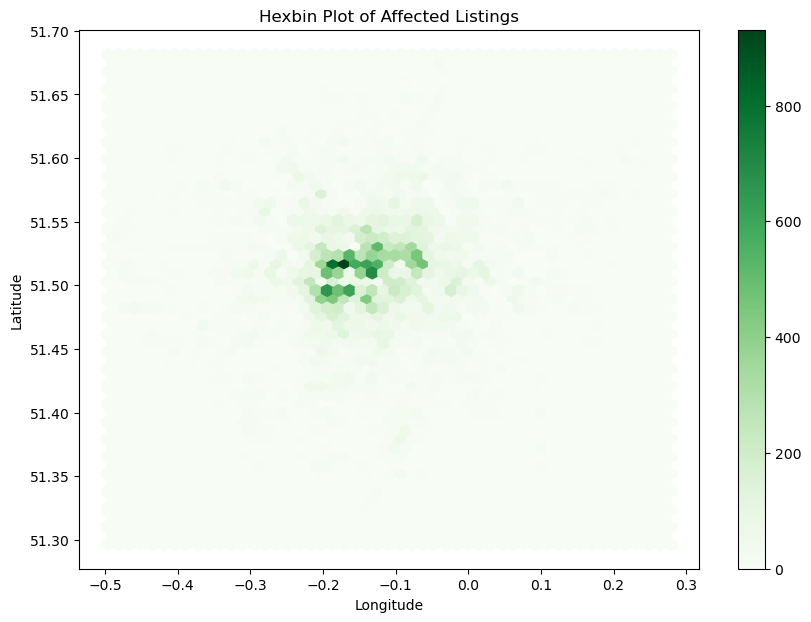

In [51]:
# 绘制 hexbin 图
pro_host_all_listings.plot.hexbin(
    x='longitude',
    y='latitude',
    gridsize=50,
    figsize=(10,7),
    cmap='Greens'
)

plt.title("Hexbin Plot of Affected Listings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

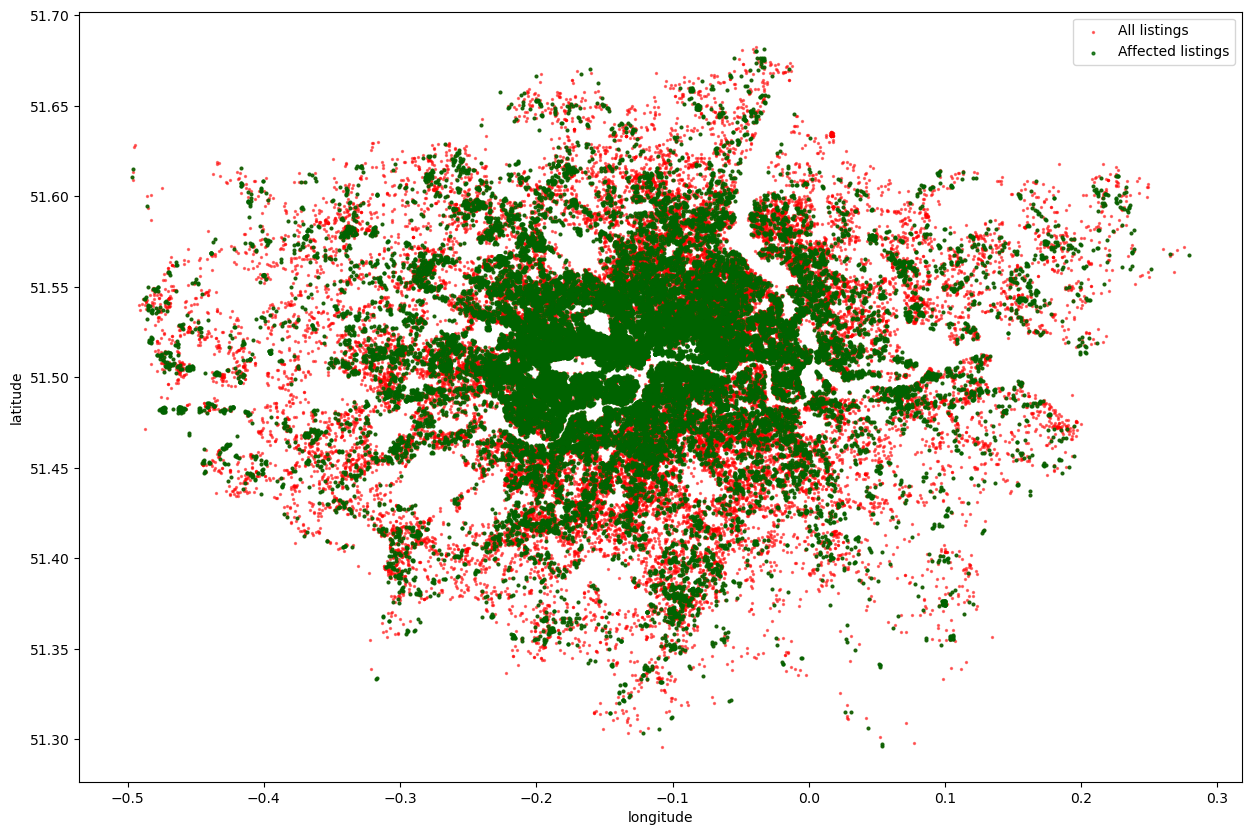

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))

gdf.plot.scatter(
    x='longitude', y='latitude',
    s=2, color='red', alpha=0.5,
    ax=ax, label='All listings'
)

pro_host_all_listings.plot.scatter(
    x='longitude', y='latitude',
    s=4, color='#006400', alpha=0.8,
    ax=ax, label='Affected listings'
)

ax.legend()
plt.show()


In [59]:
import geopandas as gpd


# 受影响房源的 GeoDataFrame
affected_gdf = gdf[
    (gdf['room_type'] == 'Entire home/apt') &
    (gdf['host_listings_count'] >= 2)
].copy()

print(type(affected_gdf))  # 应该是 GeoDataFrame

# 空间连接到 borough
affected_boro = gpd.sjoin(
    affected_gdf,                    # ⭐ 用 affected_gdf，而不是 affected
    boros[['NAME', 'geometry']],
    how='left',
    predicate='within'               # 如果这里报错，再换成 op='within'
)

<class 'geopandas.geodataframe.GeoDataFrame'>


In [60]:
affected_boro = gpd.sjoin(
    affected_gdf,
    boros[['NAME', 'geometry']],
    how='left',
    predicate='within'  # 如果版本不支持 predicate，就改成 op='within'
)

In [61]:
affected_by_boro = (
    affected_boro
    .groupby('NAME')
    .size()
    .reset_index(name='n_affected')
)

affected_by_boro.sort_values('n_affected', ascending=False).head()


,NAME,n_affected
32,Westminster,7270
19,Kensington and Chelsea,3994
5,Camden,3130
29,Tower Hamlets,2674
18,Islington,1846


In [72]:
# 把每个 borough 的受影响房源数量并回去
boros_affected = boros.merge(
    affected_by_boro,      # 有 NAME, n_affected
    on='NAME',
    how='left'
)

# 没有受影响房源的区，数量设为 0
boros_affected['n_affected'] = boros_affected['n_affected'].fillna(0)


TypeError: Legend.__init__() got an unexpected keyword argument 'label'

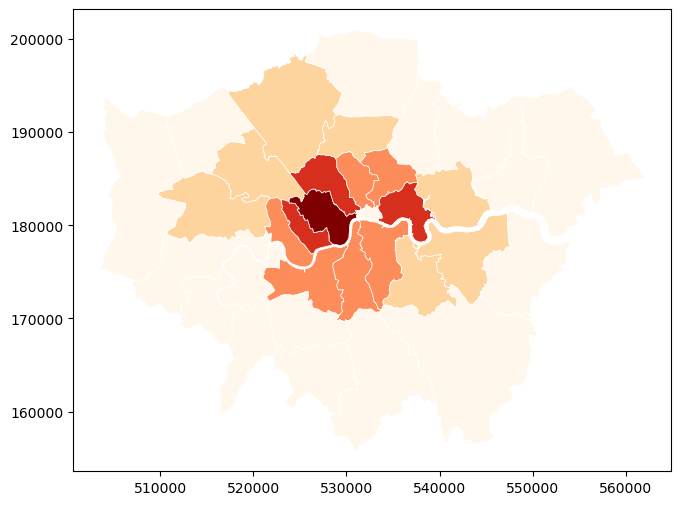

In [75]:
import matplotlib.pyplot as plt
import mapclassify as mc   # 确保有这个

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

boros_affected.plot(
    column='n_affected',
    scheme='NaturalBreaks',   # ⭐ 使用自然间断法
    k=5,                      # 分成 5 级（可自己调 4、6 等）
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': 'Number of professional listings',
        'fmt': '{:.0f}'       # 图例数字格式，不要小数
    },
    ax=ax
)

ax.set_axis_off()
ax.set_title('Number of Professional Listings by Borough (Natural Breaks)')

plt.show()


In [55]:
# RQ2： How many professional landlords are there?

In [56]:
#每个 host 拥有多少 listing（特别是 entire home）
host_summary = (
    gdf
    .groupby("host_id")
    .agg(
        host_listings=("id", "count"),
        host_entirehomes=("room_type", lambda x: (x == "Entire home/apt").sum()),
        host_wards=("neighbourhood_cleansed", "nunique")
    )
    .reset_index()
)

host_summary.head(10)

,host_id,host_listings,host_entirehomes,host_wards
0,2594,1,1,1
1,6774,6,5,1
2,9089,1,1,1
3,9323,1,0,1
4,9870,1,1,1
5,10657,1,1,1
6,10953,1,1,1
7,11431,1,1,1
8,14596,3,1,2
9,15733,1,0,1


In [62]:
# 标记是否为专业房东（拥有 ≥2 个整套房）
host_summary["is_professional"] = host_summary["host_entirehomes"] >= 2

# 合并回原始 GeoDataFrame，提取专业房东的 listings
gdf = gdf.merge(
    host_summary[["host_id", "is_professional"]],
    on="host_id", how="left"
)
pro_listings = gdf[gdf["is_professional"]].copy()

print(f"专业房东数量: {host_summary['is_professional'].sum()}")
print(f"受影响 listings 数量: {len(pro_listings)}")

专业房东数量: 5221
受影响 listings 数量: 35280


In [63]:
# 按行政区（neighbourhood_cleansed）统计受影响 listings
pro_by_area = (
    pro_listings
    .groupby("neighbourhood_cleansed")
    .agg(
        listings_total=("id", "count"),
        entire_home_count=("room_type", lambda x: (x == "Entire home/apt").sum()),
        private_room_count=("room_type", lambda x: (x == "Private room").sum()),
        pro_hosts=("host_id", pd.Series.nunique)
    )
    .sort_values("listings_total", ascending=False)
    .reset_index()
)

pro_by_area.head(10)

/tmp/ipykernel_160030/15081292.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("neighbourhood_cleansed")


,neighbourhood_cleansed,listings_total,entire_home_count,private_room_count,pro_hosts
0,Westminster,7365,6865,486,1475
1,Kensington and Chelsea,3835,3677,139,905
2,Camden,3306,2846,460,858
3,Tower Hamlets,2659,2293,366,779
4,Islington,1703,1540,163,576
5,Hammersmith and Fulham,1663,1555,107,598
6,Southwark,1529,1284,243,552
7,Hackney,1385,1269,115,467
8,Wandsworth,1320,1171,149,479
9,Lambeth,1278,1094,184,484


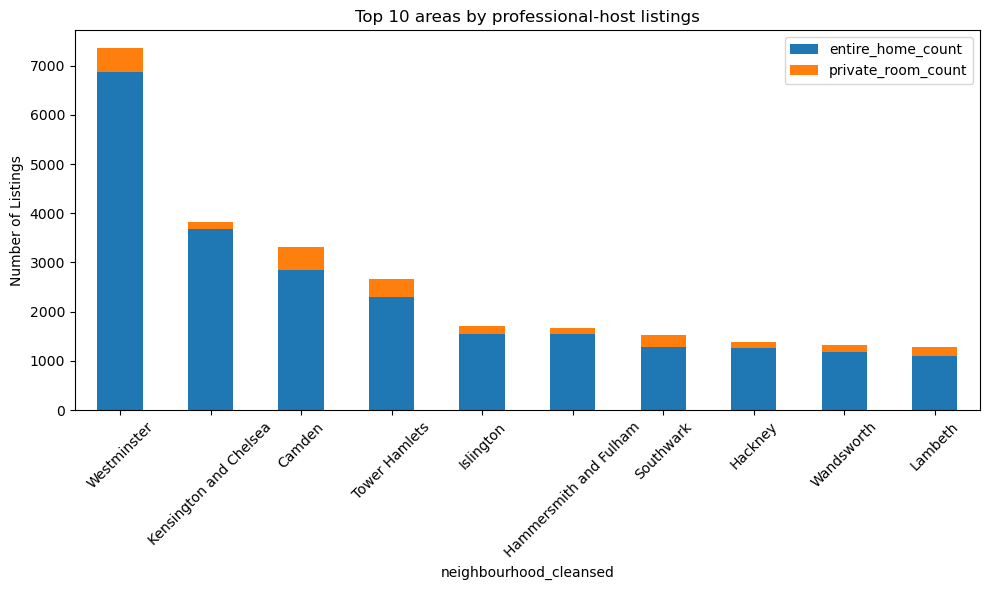

In [64]:
# 画出受影响最严重的前10个行政区
ax = pro_by_area.head(10).plot(
    x="neighbourhood_cleansed",
    y=["entire_home_count", "private_room_count"],
    kind="bar",
    stacked=True,
    figsize=(10,6),
    title="Top 10 areas by professional-host listings"
)
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# 统计每个专业房东出现的区域数
host_area_count = (
    pro_listings
    .groupby("host_id")["neighbourhood_cleansed"]
    .nunique()
    .reset_index(name="num_neighs")
)

host_area_count["is_cross_borough"] = host_area_count["num_neighs"] > 1


In [66]:
pro_listings = pro_listings.merge(
    host_area_count[["host_id", "is_cross_borough"]],
    on="host_id", how="left"
)


In [67]:
print("他们控制的房源数量：", pro_listings["is_cross_borough"].sum())
print("占专业房东 listings 的比例：", round(pro_listings["is_cross_borough"].mean() * 100, 2), "%")

他们控制的房源数量： 25690
占专业房东 listings 的比例： 72.82 %


In [68]:
#各行政区中，跨区运营 listing 占比
cross_by_neigh = (
    pro_listings
    .groupby("neighbourhood_cleansed")
    .agg(
        pro_listings=("id", "count"),
        cross_listings=("is_cross_borough", "sum")
    )
    .assign(cross_share=lambda d: d["cross_listings"] / d["pro_listings"])
    .sort_values("cross_share", ascending=False)
)

cross_by_neigh.head(10)


/tmp/ipykernel_160030/2749879366.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("neighbourhood_cleansed")


,pro_listings,cross_listings,cross_share
neighbourhood_cleansed,,,
Brent,1079,905,0.838740
City of London,417,339,0.812950
Lambeth,1278,1003,0.784820
Bexley,139,108,0.776978
Wandsworth,1320,1004,0.760606
Kensington and Chelsea,3835,2908,0.758279
Camden,3306,2498,0.755596
Islington,1703,1285,0.754551
Merton,324,243,0.750000


Room type distribution (Professional Landlords):
room_type
Entire home/apt    0.900028
Private room       0.098554
Hotel room         0.001105
Shared room        0.000312
Name: proportion, dtype: float64


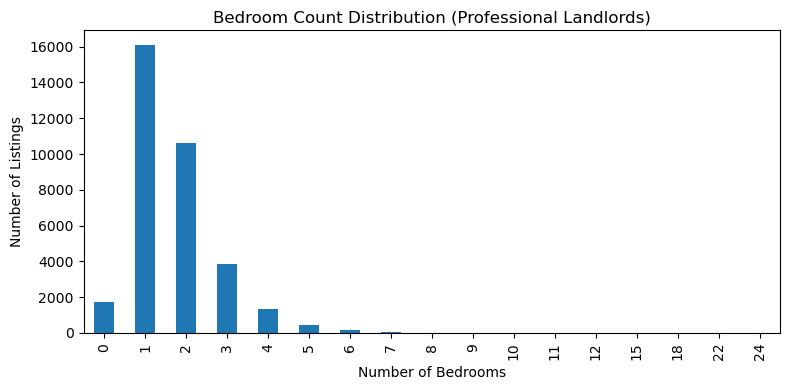

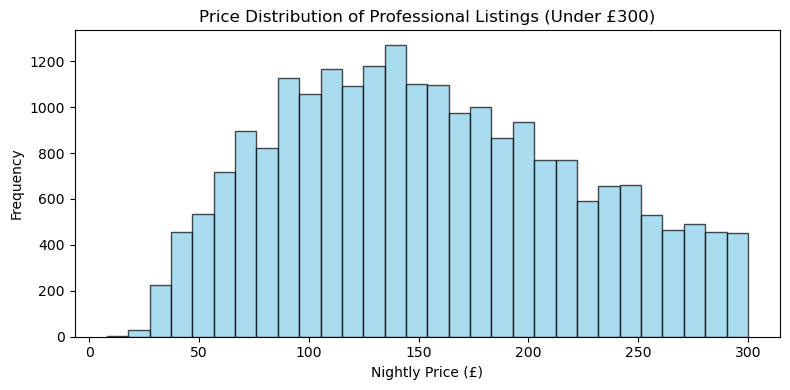

In [69]:
# Room type distribution (entire home vs private room etc.)
structure_counts = pro_listings["room_type"].value_counts(normalize=True)
print("Room type distribution (Professional Landlords):")
print(structure_counts)

# Bedroom count distribution
pro_listings["bedrooms"].dropna().astype(int).value_counts().sort_index().plot(
    kind="bar", title="Bedroom Count Distribution (Professional Landlords)", figsize=(8, 4)
)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Listings")
plt.tight_layout()
plt.show()

# Price distribution (trimmed upper limit)
filtered = pro_listings[pro_listings["price"] <= 300]

filtered["price"].plot.hist(
    bins=30,
    alpha=0.7,
    figsize=(8, 4),
    color="skyblue",
    edgecolor="black",
    title="Price Distribution of Professional Listings (Under £300)"
)
plt.xlabel("Nightly Price (£)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [70]:
print(boroughs.columns)


NameError: name 'boroughs' is not defined

In [71]:
#  Ensure both datasets have the same CRS
boroughs = boroughs.to_crs("EPSG:4326")  # Match pro_listings

# Spatial join to assign borough to each professional listing
pro_boro = gpd.sjoin(pro_listings, boroughs, how="left", predicate="intersects")

# Group by borough (using 'NAME') to aggregate stats
boro_stats = (
    pro_boro.groupby("NAME")
    .agg(
        pro_listings=("id", "count"),
        pro_hosts=("host_id", pd.Series.nunique),
        cross_borough_share=("is_cross_borough", "mean")
    )
    .reset_index()
    .rename(columns={"NAME": "borough_name"})  # for clarity
)

# Merge back to boroughs GeoDataFrame
boroughs_stats = boroughs.merge(boro_stats, left_on="NAME", right_on="borough_name", how="left")

# Plot professional listings count
boroughs_stats.plot(
    column="pro_listings",
    cmap="OrRd",
    legend=True,
    edgecolor="grey",
    figsize=(10, 6),
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Number of Professional Listings by Borough")
plt.axis("off")
plt.tight_layout()
plt.show()


NameError: name 'boroughs' is not defined